# Prepare data and libraries
Based on the ISIC Challenge 2020 train and test (both "corrected") dataset.

* https://www.isic-archive.com/
* https://challenge.isic-archive.com/data/#2020
* https://www.dicomstandard.org/ai

* curl -o ISIC_2020_Train_DICOM_corrected.zip https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Train_DICOM_corrected.zip
* curl -o ISIC_2020_Test_DICOM_corrected.zip https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Test_DICOM_corrected.zip
* curl -o ISIC_2020_Training_GroundTruth.csv https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
# The following does not seem to work :(
#!cd /opt/dlami/nvme/
#!pwd
import os
os.chdir('/mnt/efs/fs1/')
!pwd

/mnt/efs/fs1


In [3]:
## To load local modules, not sure if this works
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

(Optional) Define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [7]:
# If you have google colab gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 32.6 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Custom Dataset
Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Based on https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [9]:
import pathlib
import numpy as np

In [10]:
csv_file_name='./ham/HAM10000_metadata.csv'
root_dir_name="./ham/health_small"

data_dir = pathlib.Path(root_dir_name) # NB: changing type froom str to Path
file_paths = list(data_dir.glob('*/*.jpg'))
image_count = len(file_paths)
print(image_count)
for i in range(image_count):
    file_path = file_paths[i]
    print(f"file_path={file_path}")
    if( i > 10 ):
        break

1923
file_path=ham/health_small/bcc/ISIC_0028079.jpg
file_path=ham/health_small/bcc/ISIC_0032696.jpg
file_path=ham/health_small/bcc/ISIC_0032302.jpg
file_path=ham/health_small/bcc/ISIC_0028871.jpg
file_path=ham/health_small/bcc/ISIC_0032777.jpg
file_path=ham/health_small/bcc/ISIC_0026855.jpg
file_path=ham/health_small/bcc/ISIC_0030403.jpg
file_path=ham/health_small/bcc/ISIC_0025793.jpg
file_path=ham/health_small/bcc/ISIC_0029951.jpg
file_path=ham/health_small/bcc/ISIC_0033301.jpg
file_path=ham/health_small/bcc/ISIC_0028583.jpg
file_path=ham/health_small/bcc/ISIC_0024848.jpg


In [11]:
import pathlib
from torch.utils.data import Dataset
#from torchvision.io import read_image

# Three ways of reading images (two in the tutorials)
# Transforms are designed for Scikit-image, however, decided to use Torchvision
# Torchvision returns tensor (can be converted to PIL for displaying)
# Scikit-image returns numpy skimage.io.imread(os.path.join('data/faces/', img_name)
# PIL returns pillow object me thinks PIL.Image.open(image_path)
# https://stackoverflow.com/questions/68207510/how-to-use-torchvision-io-read-image-with-image-as-variable-not-stored-file
#import skimage

import pandas as pd
import os

class HamDataset(Dataset):
    """Ham dataset"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # We really only need a list of str file paths, no need for root_dir
        # more of a convenience.  Support both root_dir or list of filepaths
        if( type(root_dir) == str ):
            #print("USING ROOT DIR")
            # The dataframe metadata may have  more records than we have
            # files in the directory, so use the files
            #data_path = pathlib.Path(root_dir) # NB: changing type from str to Path
            #self.file_paths = list(data_path.glob('*/*.jpg'))
    
            # Prefer pure Python str to posixpath, causes lots of problems otherwise
            data_path = pathlib.Path(root_dir) # NB: changing type from str to Path
            self.file_paths = list()
            for posixpath in list(data_path.glob('*/*.jpg')):
                self.file_paths.append( str(posixpath) )
        elif( type(root_dir) == list ):
            #print("USING LIST")
            self.file_paths = root_dir
        else:
            raise ValueError(f"Unsupported type for root_dir {type(root_dir)}")
        
        
        self.image_count = len(self.file_paths)
        #print(image_count)
        #for i in range(image_count):
        #    file_path = file_paths[i]
        # Manually map target to ints   (required for models)
        self.class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        
    
    def __len__(self):
        return self.image_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        file_path = self.file_paths[idx]
        row = self.lookup_path( file_path )

        #img_name = sample['imgid']
        #image = io.imread(img_name)
        # Frankly not sure why we don't just store as Pytorch tensor
        # example stores as a numpy image and then transforms
        # In any cases, the dimensions are different and so code is not compatible
        # specifically the resize and crop are written for numpy :(
        # Perhaps one day can rewrite for tensors but fine for now
        #image_tensor = torchvision.io.read_image( str(file_path) )
        #sample['image'] = image_tensor
        
        image_np = skimage.io.imread(file_path) # dtype=uint8
        # [[[209 155 181]
        #  [210 154 183]
        #  [209 154 183]
        #  ...
        # need float32, also imshow, if float, expects  between [0,1]
        # This is also perhaps nice for training as normalised.
        image_np = np.float32(image_np)/255.0
        #print( f"image_np={image_np.dtype}" )
        label = self.class_names.index( row['dx'] )
        sample = (image_np, label)

        # apply any transforms, e.g. resize, crop
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_class_names( self ):
        return self.class_names

    def get_class( self, index ):
        return self.class_names[index]

    def get_index( self, file_path ):
        return self.file_paths.index(file_path)

    def get_file_path( self, idx ):
        return self.file_paths[idx]
    
    def lookup_path( self, file_path ):
        """
        file_path (type Path) of the file (e.g. ISIC_0034214)
        returns list [lesion_id, image_id, dx, dx_type, age, sex, localization]
        """
        # file_path=ham/health_tiny/bcc/ISIC_0028079.jpg
        #   lesion_id   image_id        dx  dx_type age     sex localization
        # 0	HAM_0000118 ISIC_0027419    bkl histo   80.0    male    scalp
        # 1	HAM_0000118 ISIC_0025030    bkl histo   80.0    male    scalp
        #imgid = file_path.split("/")[-1]
        imgid = os.path.basename(file_path)
        # Get rid of extension so can exactly match the dataframe image_id
        imgid = imgid.replace(".jpg", "")
        row = self.metadata_df.loc[ self.metadata_df["image_id"] == imgid ]
        #print(f.numpy())
        #print( imgid )
        #print( row )
        # lesion_id      image_id  dx    dx_type   age   sex     localization
        # the row lookup returns a dataframe or series, but just one value, use iat
        lesion_id = row["lesion_id"].iat[0]
        dx      = row["dx"].iat[0]
        dx_type = row["dx_type"].iat[0]
        age     = row["age"].iat[0]
        sex     = row["sex"].iat[0]
        location= row["localization"].iat[0]
        sample = {'lesion_id': lesion_id, 'imgid': imgid, 'file_path': file_path, 'dx': dx,
                  'dx_type': dx_type, 'age': age, 'sex': sex, 'location': location}
        return sample

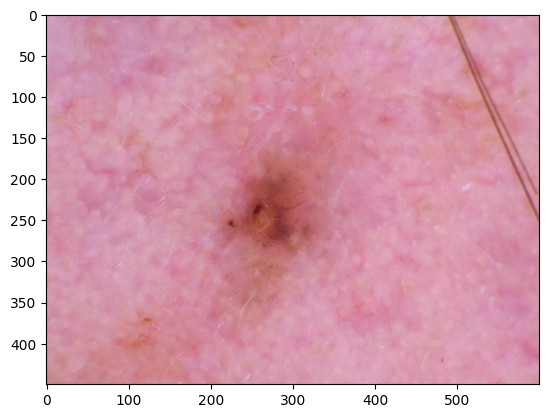

float32


In [12]:
import torchvision.transforms.functional as transform
#from skimage import io
import skimage
def show_skin_image(image_np):
    """Show image"""
    plt.imshow(image_np)
    
    #new_PIL_image = transform.to_pil_image(image_tensor) 
    #plt.imshow(new_PIL_image)
    
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
image_np = skimage.io.imread('ham/health_tiny/bcc/ISIC_0031284.jpg')
image_np = np.float32(image_np)/255.0
#image_tensor = torchvision.io.read_image( 'ham/health_tiny/bcc/ISIC_0031284.jpg' )
show_skin_image(image_np)
plt.show()
print(image_np.dtype)

0 (450, 600, 3) 1


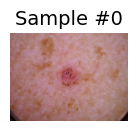

1 (450, 600, 3) 1


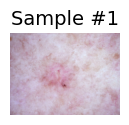

2 (450, 600, 3) 1


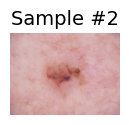

3 (450, 600, 3) 1


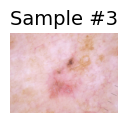

In [13]:
ham_dataset = HamDataset(csv_file=csv_file_name, root_dir=root_dir_name)

fig = plt.figure()

for i, sample in enumerate(ham_dataset):
    image_tensor, label = sample
    print(i, image_tensor.shape, label)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_skin_image( image_tensor )
    
    if i == 3:
        plt.show()
        break

In [14]:
import numpy as np
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(image, (new_h, new_w))

        return (img, label)


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return (image, label)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        #print(image_np.dtype) = uint8
        # default numpy type is float64, causes issues as models expect float32 :(
        return (torch.from_numpy(image), label)

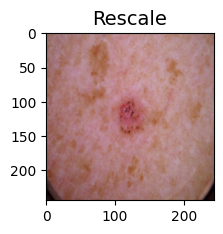

In [15]:
#from torchvision.transforms import v2

#scale = Rescale(256)
scale = Rescale( (244,244) )
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = ham_dataset[0]
#for i, tsfrm in enumerate([scale, crop, composed]):
for i, tsfrm in enumerate([scale]):
    image, label = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_skin_image(image)

plt.show()

Iterating through the dataset
Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly

Transforms are applied on the read image

Since one of the transforms is random, data is augmented on sampling

We can iterate over the created dataset with a for i in range loop as before.

In [16]:
transformed_dataset = HamDataset(  csv_file=csv_file_name,
                                   root_dir=root_dir_name,
                                   transform=transforms.Compose([
                                       Rescale( (224,224) ),
                                       #RandomCrop(224),
                                       ToTensor()
                                    ]))

for i, sample in enumerate(transformed_dataset):
    image, label = sample
    print(i, image.size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

0 2
1 2
2 2
3 2


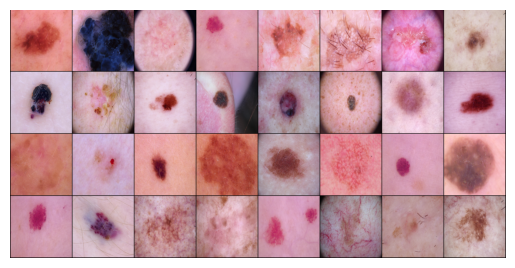

In [17]:
from torch.utils.data import DataLoader
from torchvision import utils

num_threads = 16 - 2 # assuming 16 CPUs

batch_size = 32
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch = sample_batched
    batch_size = len(images_batch)
    #print(f"batch_size={batch_size}")
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    # NB sample_batched should always be 2, two lists
    #   list of batch_size for images
    #   list of batch_size for labels
    print(i_batch, len(sample_batched) ) 

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [18]:
class_names = transformed_dataset.get_class_names()

total = len(transformed_dataset)
train = int(0.7 * total)
test  = total - train
print(  f"train={train}  test={test}" )
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [train, test])

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_threads)
valloader   = DataLoader(val_set,   batch_size=batch_size, shuffle=True, num_workers=num_threads)

train=1346  test=577


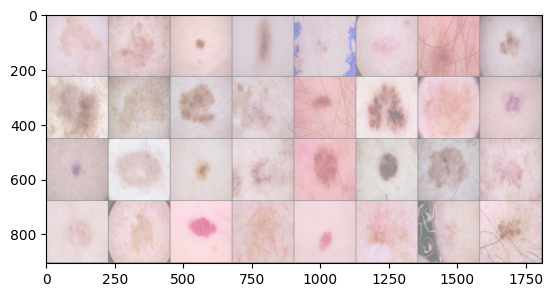

bkl   nv    mel   nv    bcc   bcc   nv    mel   akiec bkl   nv    bcc   nv    akiec akiec vasc  vasc  akiec bkl   bcc   nv    bkl   mel   bcc   bcc   bkl   vasc  mel   vasc  akiec akiec bcc  


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

In [20]:
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets

import time

## Transfer Learning CNN

Taken from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate

Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [38]:
from tempfile import TemporaryDirectory

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {"train":trainloader, "val":valloader}
#class_names = image_datasets['train'].classes


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                dataset_size = 0
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        #print(f"LABELS: {labels}")
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    dataset_size += inputs.size(0)
                    # print(f"inputs.size(0)={inputs.size(0)}") size(0) is the batch_size
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                #epoch_loss = running_loss / dataset_sizes[phase]
                #epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [39]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv.fc = nn.Linear(num_ftrs, len(class_names) )

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [40]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.8438 Acc: 0.2556
val Loss: 1.6057 Acc: 0.4003

Epoch 1/24
----------
train Loss: 1.4636 Acc: 0.4718
val Loss: 1.3728 Acc: 0.4853

Epoch 2/24
----------
train Loss: 1.3173 Acc: 0.5104
val Loss: 1.2905 Acc: 0.5477

Epoch 3/24
----------
train Loss: 1.2191 Acc: 0.5535
val Loss: 1.2638 Acc: 0.5165

Epoch 4/24
----------
train Loss: 1.1774 Acc: 0.5624
val Loss: 1.1831 Acc: 0.5650

Epoch 5/24
----------
train Loss: 1.1211 Acc: 0.5958
val Loss: 1.1984 Acc: 0.5633

Epoch 6/24
----------
train Loss: 1.0733 Acc: 0.6129
val Loss: 1.1449 Acc: 0.5875

Epoch 7/24
----------
train Loss: 1.0274 Acc: 0.6441
val Loss: 1.1380 Acc: 0.5806

Epoch 8/24
----------
train Loss: 1.0017 Acc: 0.6456
val Loss: 1.1377 Acc: 0.5789

Epoch 9/24
----------
train Loss: 0.9972 Acc: 0.6478
val Loss: 1.1333 Acc: 0.5893

Epoch 10/24
----------
train Loss: 0.9875 Acc: 0.6597
val Loss: 1.1475 Acc: 0.5737

Epoch 11/24
----------
train Loss: 0.9956 Acc: 0.6493
val Loss: 1.1502 Acc: 0.5806

Ep

In [41]:
PATH = './ham_transfer_model.pth'
torch.save(model_conv.state_dict(), PATH)

In [43]:
model = model_conv
torch.load(model.state_dict(), PATH) # This fails for some reason

AttributeError: 'collections.OrderedDict' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

### Custom CNN trained from scratch.

In [70]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Expects images of h=224, w=224
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(7,7), stride=1, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(64*56*56, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 7)
        #self.softmax = nn.Softmax( dim=0 ) # expect  only one dim

        # Initialise
        self._init_weights(self.conv1)
        self._init_weights(self.conv2)
        self._init_weights(self.fc3)
        self._init_weights(self.fc4)

    def _init_weights(self, module):
        #print(f"Initialising module {module}")
        # https://saturncloud.io/blog/how-to-initialize-weights-in-pytorch-a-guide-for-data-scientists/
        # https://wandb.ai/wandb_fc/tips/reports/How-to-Initialize-Weights-in-PyTorch--VmlldzoxNjcwOTg1
        nn.init.xavier_normal_(module.weight)
        # nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu') # He
        #if isinstance(module, nn.Linear):
        #    module.weight.data.normal_(mean=0.0, std=1.0)
        #    if module.bias is not None:
        #        module.bias.data.zero_()

    
    def forward(self, x):
        verbose = False
        #=========================#
        # input 3x224x224
        x = self.act1(self.conv1(x))
        # output 32x224x224

        # input 32x224x224 
        x = self.pool1(x)
        # output 32x112x112
        if verbose: print(f"output group1 {x.shape}")

        #=========================#
        # input 32x112x112
        x = self.act2(self.conv2(x))
        # input 64x112x112
        
        # input 64x112x112
        x = self.pool2(x)
        # output 64x56x56
        if verbose: print(f"output group2 {x.shape}")

        #=========================#
        # input 64x56x56
        x = self.flat(x)
        # output (64x56x56)
        if verbose: print(f"output flatten {x.shape}")

        #=========================#
        # input (64x56x56)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # output (512)
        if verbose: print(f"output group3 {x.shape}")

        #=========================#
        # input (512)
        x = self.fc4(x)
        #  output (7)
        if verbose: print(f"output group4 {x.shape}")
        
        # Finally pass through a softmax
        #x = self.softmax(x)
        return x


model = Net()

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

### Training on GPU?
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [24]:
num_epochs = 30
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 16 == 0:
            print(f'    epoch {epoch+1} batch {i}: loss: {running_loss:.6f}')
        #if i % 100 == 99:    # print every 100 batches
        #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.6f}')
        #    running_loss = 0.0
    print(f'epoch {epoch + 1}/{num_epochs}: loss: {running_loss:.6f}')

print('Finished Training')

    epoch 1 batch 0: loss: 1.979831
    epoch 1 batch 16: loss: 32.870839
    epoch 1 batch 32: loss: 63.003440
epoch 1/30: loss: 81.883101
    epoch 2 batch 0: loss: 1.821849
    epoch 2 batch 16: loss: 31.953077
    epoch 2 batch 32: loss: 61.459677
epoch 2/30: loss: 79.408149
    epoch 3 batch 0: loss: 1.853790
    epoch 3 batch 16: loss: 30.527533
    epoch 3 batch 32: loss: 58.674963
epoch 3/30: loss: 76.510185
    epoch 4 batch 0: loss: 1.703395
    epoch 4 batch 16: loss: 29.690817
    epoch 4 batch 32: loss: 58.332278
epoch 4/30: loss: 75.895248
    epoch 5 batch 0: loss: 1.693454
    epoch 5 batch 16: loss: 29.452171
    epoch 5 batch 32: loss: 56.556771
epoch 5/30: loss: 74.058049
    epoch 6 batch 0: loss: 1.548239
    epoch 6 batch 16: loss: 29.217849
    epoch 6 batch 32: loss: 55.196384
epoch 6/30: loss: 71.306971
    epoch 7 batch 0: loss: 1.326544
    epoch 7 batch 16: loss: 28.052558
    epoch 7 batch 32: loss: 54.767303
epoch 7/30: loss: 70.672276
    epoch 8 batch 0:

Let’s quickly save our trained model:

In [26]:
PATH = './ham_model.pth'
torch.save(model.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

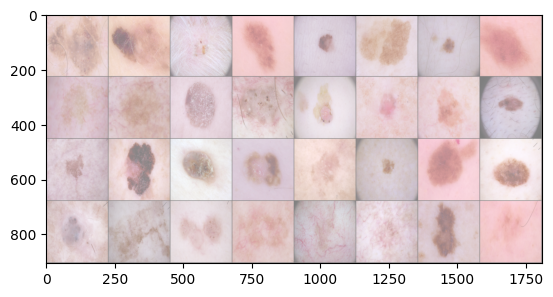

GroundTruth:  bkl   mel   bcc   nv    nv    bkl   mel   nv    bkl   mel   bkl   bkl   bkl   bkl   bkl   mel   bkl   mel   bkl   bkl   akiec mel   nv    mel   bcc   bkl   bcc   akiec bkl   akiec mel   nv   


In [27]:
testloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_threads)
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [42]:
model = Net()
model.load_state_dict(torch.load(PATH))

NameError: name 'Net' is not defined

Okay, now let us see what the neural network thinks these examples above are:

In [44]:
outputs = model(images)

The outputs are probablities for the 7 classes. The higher the prob for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [45]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  bkl   akiec nv    nv    vasc  bcc   nv    mel   mel   bkl   mel   bcc   nv    mel   akiec vasc  vasc  bcc   mel   akiec nv    mel   bkl   akiec bcc   bkl   vasc  akiec vasc  akiec bkl   bcc  


The results seem pretty good. (humm)

Let us look at how the network performs on the whole dataset.

In [47]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(val_set)} test images: {100 * correct // total} %')

Accuracy of the network on the 577 test images: 60 %


What are the classes that performed well, and the classes that did not perform well:

In [48]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: akiec is 55.0 %
Accuracy for class: bcc   is 68.0 %
Accuracy for class: bkl   is 66.1 %
Accuracy for class: df    is 19.4 %
Accuracy for class: mel   is 52.7 %
Accuracy for class: nv    is 68.9 %
Accuracy for class: vasc  is 77.8 %


# Exploratory Data  Analysis

In [21]:
metadata_df=pd.read_csv(csv_file_name)
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [22]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [23]:
#Checking for NA
metadata_df.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [24]:
metadata_df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0032258,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [25]:
import seaborn as sns

/tmp/ipykernel_2031/965421305.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata_df)


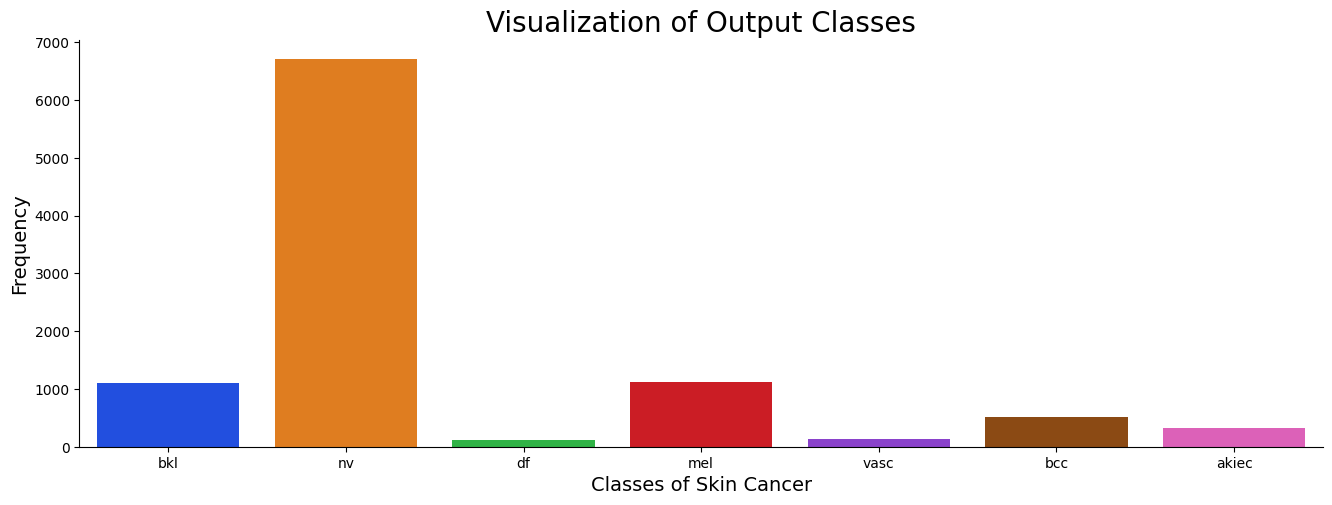

In [26]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)
plt.show()

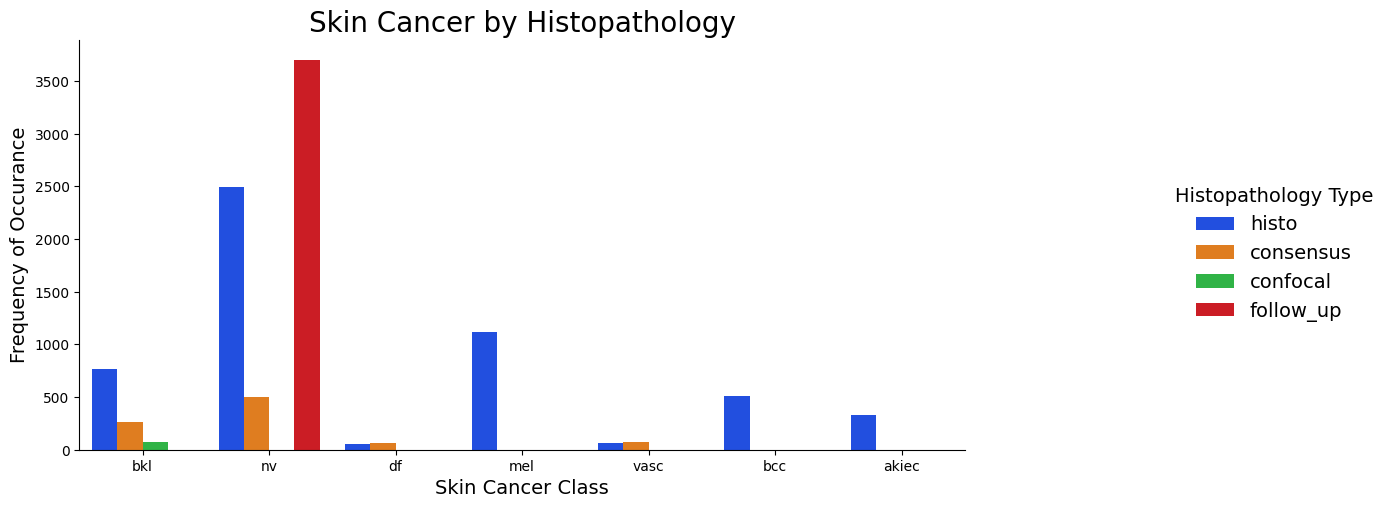

In [27]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')
plt.show()

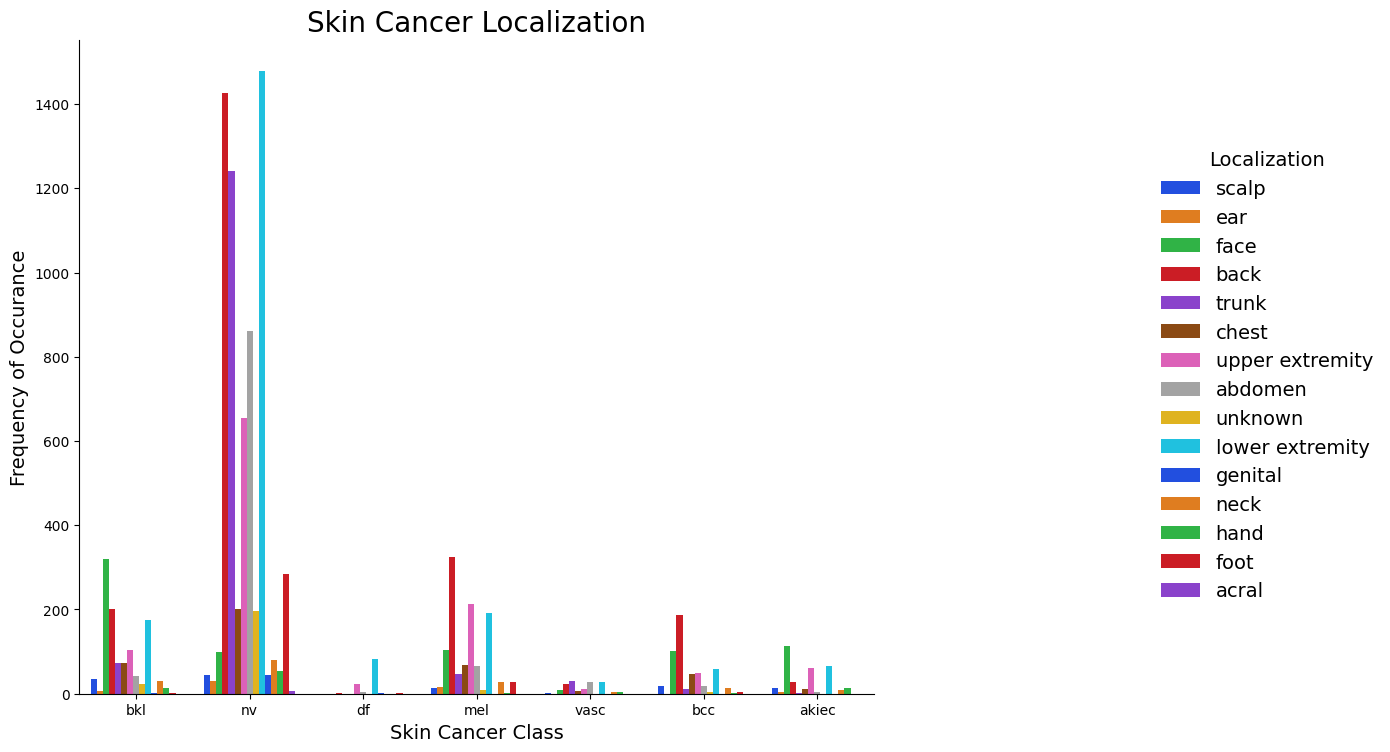

In [28]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')
plt.show()

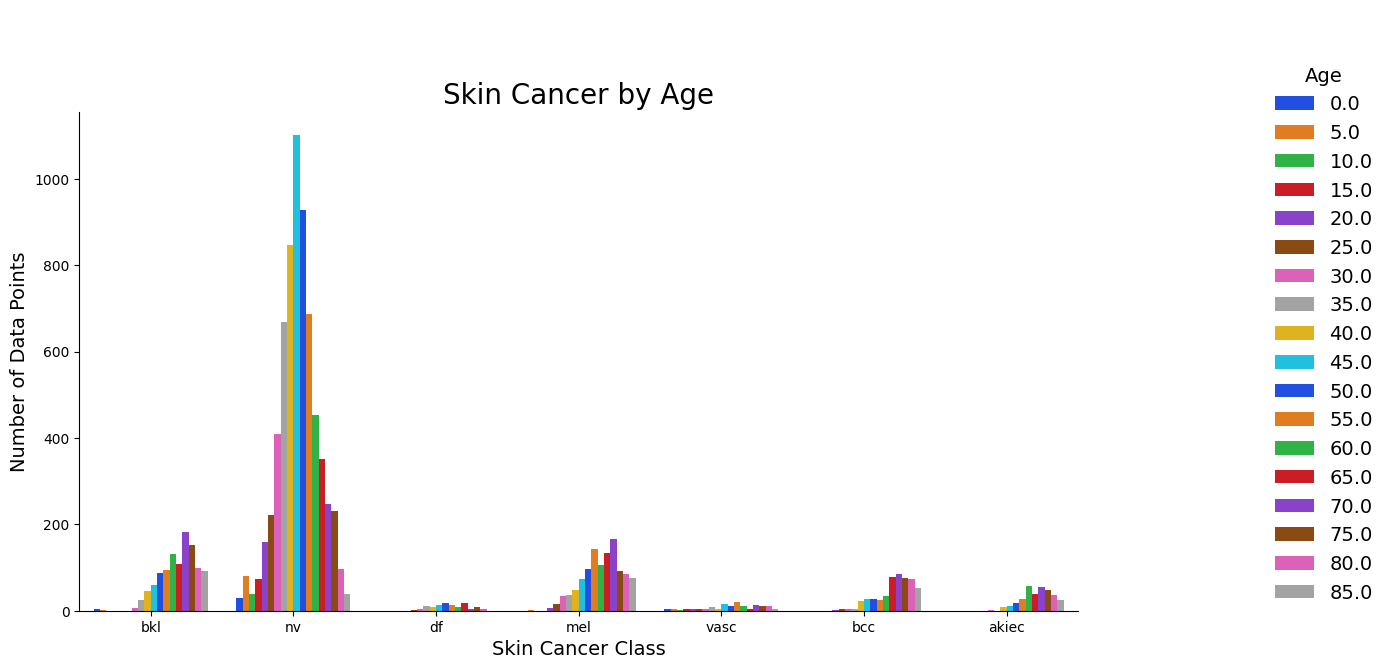

In [29]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')
plt.show()

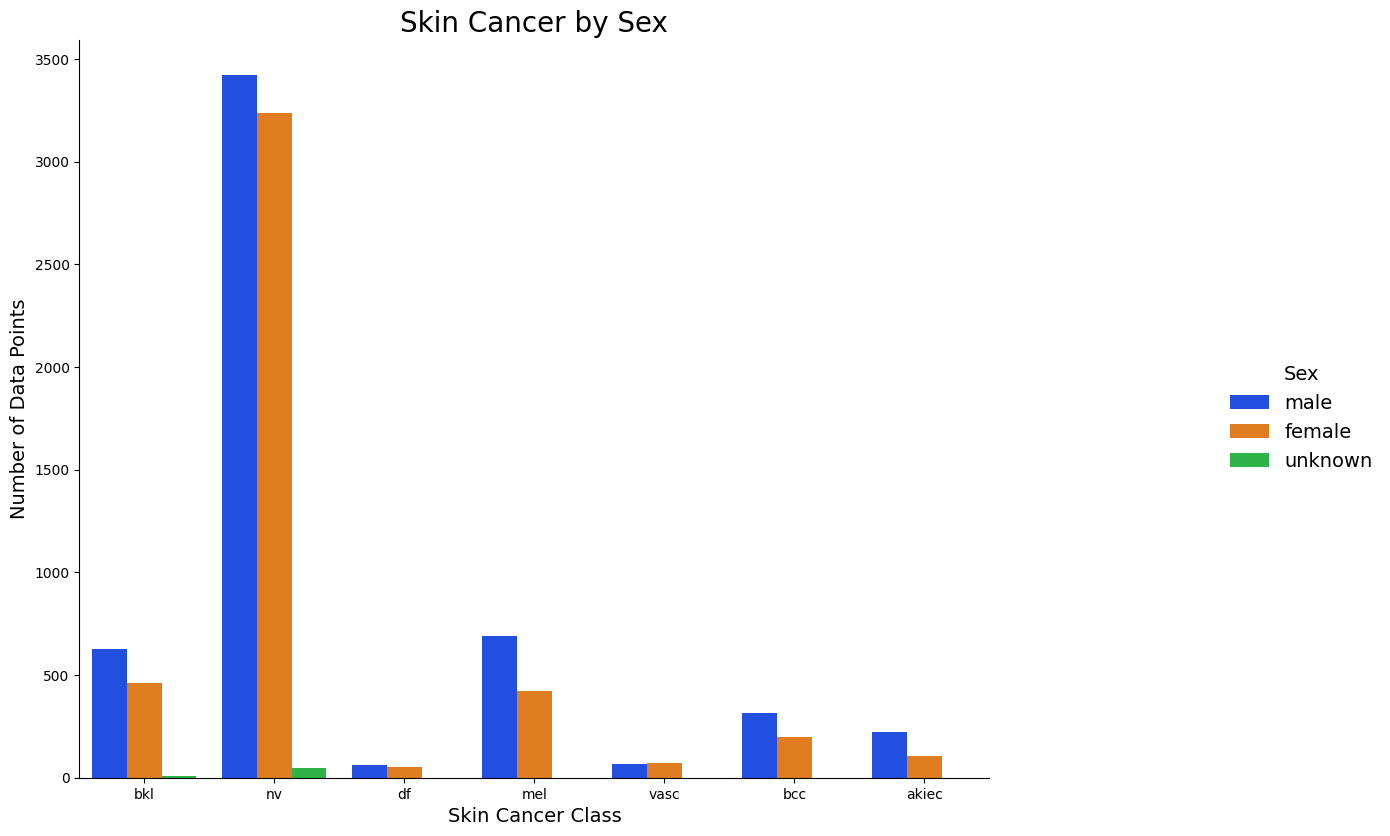

In [30]:
# Skin Cancer occurence by Sex
g = sns.catplot(x="dx", kind="count", hue="sex", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')
plt.show()

# Fairness Analysis
Create a custom CNN model and train on the data.  Evaluate using the validation set to estimate the model's accuracy.

In [49]:
# see https://github.com/DataResponsibly/courses/blob/master/documents/spring20/RDS_Lab_2_2020.ipynb

# Read in again, makes this section more independent
metadata_df=pd.read_csv(csv_file_name)

#  Thought 'unknown' sex might cause problems, but likely ok, can comment to find out
#metadata_df = metadata_df[metadata_df.sex != 'unknown']
# Turns out was issue with row with missing values
# AI360 StandardDataset drops them and then does not align with y_pred
metadata_df.dropna(inplace=True) # causes issue with AI360 StandardDataset

metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [50]:
metadata_sample_df = metadata_df.sample(batch_size*20, random_state=123456)
#metadata_sample_df = metadata_df.sample( batch_size*10 )
print(class_names)
metadata_sample_df.head()

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization
9742,HAM_0001258,ISIC_0025331,akiec,histo,80.0,male,face
7870,HAM_0006182,ISIC_0033789,nv,histo,35.0,male,abdomen
5632,HAM_0006045,ISIC_0029910,nv,follow_up,50.0,male,trunk
1431,HAM_0002115,ISIC_0032408,mel,histo,60.0,female,upper extremity
9333,HAM_0004646,ISIC_0030557,nv,consensus,25.0,male,back


In [51]:
# See https://discuss.pytorch.org/t/how-to-retrieve-the-sample-indices-of-a-mini-batch/7948/19
# https://discuss.pytorch.org/t/how-does-one-obtain-indicies-from-a-dataloader/16847/7
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """
    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index
    
    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
HamDatasetWithIndices = dataset_with_indices(HamDataset)
#dataset = MNISTWithIndices('~/datasets/mnist')

Create a new dataset with all the images.

In [52]:
eval_file_paths = list()
for index_df, row in metadata_sample_df.iterrows():
    # health_small/nv/ISIC_0027761.jpg
    dx = row['dx']
    image_id = row['image_id']
    #file_path = f"{root_dir_name}/{dx}/{image_id}.jpg"
    file_path = f"ham/health/{dx}/{image_id}.jpg"
    eval_file_paths.append(file_path)
    #print( f"{index}: dx={dx}  image_id={image_id} file_path={file_path}" )

# This results in data = (img, label, index) instead of just (img,label)
# The index is lookup into the dataset, e.g. eval_dataset[index]
eval_dataset = HamDatasetWithIndices( csv_file=csv_file_name,
                           root_dir=eval_file_paths,
                           transform=transforms.Compose([
                               Rescale( (224,224) ),
                               #RandomCrop(224),
                               ToTensor()
                            ]))
print(f"Evaluation Dataset contains {len(eval_dataset)} instances")
print(f"Dataframe has {metadata_sample_df.shape}")
print(f"List eval_file_paths has {len(eval_file_paths)}")

Evaluation Dataset contains 640 instances
Dataframe has (640, 7)
List eval_file_paths has 640


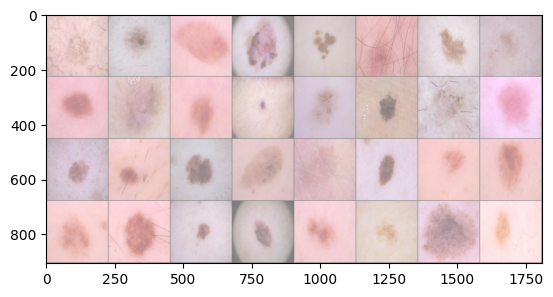

GroundTruth:  akiec nv    nv    mel   nv    nv    mel   nv    nv    df    nv    bcc   nv    nv    bkl   nv    nv    nv    nv    bkl   bkl   nv    nv    nv    nv    nv    nv    nv    nv    nv    nv    nv   


In [53]:
evalloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
dataiter = iter(evalloader)
images, labels, indexes = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

In [54]:
y_true = list()
y_pred = list()
samples= list()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
k = 0
with torch.no_grad():
    for data in evalloader:
        # My hope is that the loader (we can shuffle because index is returned) and dataframe are "aligned"
        # Confirmed that this is indeed the case with the modified datase "with indices"
        images, labels, indexes = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(f"=== Batch === {predicted}")
        for i in range(len(predicted)):
            output = outputs[i]
            pred  = predicted[i]
            label = labels[i]
            index = indexes[i]
            
            # Sanity check
            file_path = eval_dataset.get_file_path(index)
            sample = eval_dataset.lookup_path(file_path)

            y_true.append(label)
            y_pred.append(pred)
            samples.append(sample)
            
            if( class_names[label] != sample['dx'] ):
                raise ValueError(f"Dataset and loader misaligned for {sample} and index {index}")
            #print(f"output={output} label={label} ({class_names[label]}) pred={pred} index={index}")
            # Make sure order of y_true and y_pred align with dataframe (used to create dataset)
            #print(f"sample={sample}")
            #print(f"row={metadata_sample_df.iloc[int(index)]}")

#print(f'Accuracy of the network on the {len(eval_dataset)} test images: {100 * correct // total} %')

mycorrect = 0
mytotal = 0
for i in range(len(y_true)):
    if( y_pred[i] == y_true[i] ):
        mycorrect += 1
    mytotal += 1
print(f"Total={mytotal} correct={mycorrect} my accuracy={mycorrect/mytotal:.3f}")

Total=640 correct=416 my accuracy=0.650


In [55]:
# Custom calculation of sex disparate impact
numInstancesUnprivileged = 0
numPositivesUnprivileged = 0
numInstancesPrivileged   = 0
numPositivesPrivileged   = 0

for i in range( len(samples) ):
    sample = samples[i]
    sex = sample['sex']
    dx  = sample['dx']

    y_hat = y_pred[i]
    y     = y_true[i]
    

    #positive_predictions = [1,4] # bcc, mel
    positive_outcome = False
    if( y == y_hat ):
        positive_outcome = True

    #print(f"{i}: y_hat={y_hat} y={y} {positive_outcome} sex={sex}")
    if( sex == "male" ):
        #print(f"  male {correct_male}  y_hat={y_hat} y={y} {positive_outcome}")
        #if (y == y_hat):
        if (y == 1 and y_hat == 1) or (y == 4 and y_hat == 4):
            numPositivesPrivileged += 1
        numInstancesPrivileged += 1
    elif( sex == "female" ):
        #if (y == y_hat):
        if (y == 1 and y_hat == 1) or (y == 4 and y_hat == 4):
            numPositivesUnprivileged += 1
        numInstancesUnprivileged += 1
    else:
        print(f"Unknown sex {sex}")

print(f"numPositivesUnprivileged = {numPositivesUnprivileged:.4f}")
print(f"numInstancesUnprivileged = {numInstancesUnprivileged:.4f}")
print(f"numPositivesPrivileged   = {numPositivesPrivileged:.4f}")
print(f"numInstancesPrivileged   = {numInstancesPrivileged:.4f}")



protected     = numPositivesUnprivileged / numInstancesUnprivileged
non_protected = numPositivesPrivileged / numInstancesPrivileged
print(f"P(positive outcome | protected)     = {protected:.4f}")
print(f"P(positive outcome | non-protected) = {non_protected:.4f}")
print(f"DI = {protected/non_protected:.4f}")

# "numPositivesUnprivileged": 21.0,
# "numInstancesUnprivileged": 314.0,
# "numPositivesPrivileged": 23.0,
# "numInstancesPrivileged": 325.0,

Unknown sex unknown
numPositivesUnprivileged = 29.0000
numInstancesUnprivileged = 314.0000
numPositivesPrivileged   = 38.0000
numInstancesPrivileged   = 325.0000
P(positive outcome | protected)     = 0.0924
P(positive outcome | non-protected) = 0.1169
DI = 0.7899


In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(class_names)
metadata_sample_df["dx"] = le.transform(metadata_sample_df["dx"])
sex_labels = np.array( ['male','female','unknown'] ) # NOT SURE WHY THIS IS NOT WORKING, female should be 1
le.fit(sex_labels)
metadata_sample_df["sex"] = le.transform( metadata_sample_df["sex"] )
#metadata_df = pd.get_dummies(metadata_df, columns=['sex', 'localization'])

#metadata_sample_df = pd.get_dummies(metadata_df, columns=['dx'])
metadata_sample_df.drop(["image_id", "lesion_id", "dx_type", "localization"], axis=1, inplace=True)

In [57]:
# https://stackoverflow.com/questions/64506977/calculate-group-fairness-metrics-with-aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

import json
from collections import OrderedDict

dataset = StandardDataset(metadata_sample_df, 
                          label_name='dx', 
                          favorable_classes=[1,4], 
                          protected_attribute_names=['sex'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred):
    # Be careful, dataset can remove a record and not align with y_pred
    # Will get string errors about "cannot broadcast..." with off by one
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    #print(f"len(y_pred)={len(y_pred)}")
    #print(f"dataset_pred={dataset_pred}")
    #print(f"unprivileged_groups={unprivileged_groups}")
    #print(f"privileged_groups={privileged_groups}")
    
    class_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)    
    bin_metric = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    
    #result = {'disparate_impact': metric_pred.disparate_impact(),
    #         'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
    return bin_metric, class_metric


bin_metric, class_metric = fair_metrics(dataset, np.array(y_pred) )

2024-03-23 14:35:20.429088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 14:35:31.682460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [59]:
result = {'statistical_parity_difference': bin_metric.statistical_parity_difference(),
         'disparate_impact': bin_metric.disparate_impact(),
         'equal_opportunity_difference': class_metric.equal_opportunity_difference()}
print(result)

{'statistical_parity_difference': -0.049828515433610984, 'disparate_impact': 0.5951433121019107, 'equal_opportunity_difference': -0.07407407407407407}


In [60]:
def format_json(json_str):
    return json.dumps(json.loads(json_str, object_pairs_hook=OrderedDict), indent=2)

json_expl = MetricJSONExplainer(bin_metric)
json_str = json_expl.mean_difference()
print( format_json(json_str) )

dict_mean_difference= json.loads(json_str, object_pairs_hook=OrderedDict) # returns type OrderedDict


protected = dict_mean_difference["numPositivesUnprivileged"] / dict_mean_difference["numInstancesUnprivileged"]
non_protected     = dict_mean_difference["numPositivesPrivileged"] / dict_mean_difference["numInstancesPrivileged"]
print(f"P(positive outcome | protected)     = {protected:.4f}")
print(f"P(positive outcome | non-protected) = {non_protected:.4f}")
print(f"DI = {protected/non_protected:.4f}")

#print( type( dict_mean_difference ) )

{
  "metric": "Mean Difference",
  "message": "Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.049828515433610984",
  "numPositivesUnprivileged": 23.0,
  "numInstancesUnprivileged": 314.0,
  "numPositivesPrivileged": 40.0,
  "numInstancesPrivileged": 325.0,
  "description": "Computed as the difference of the rate of favorable outcomes received by the unprivileged group to the privileged group.",
  "ideal": "The ideal value of this metric is 0.0"
}
P(positive outcome | protected)     = 0.0732
P(positive outcome | non-protected) = 0.1231
DI = 0.5951
